<a href="https://colab.research.google.com/github/prasadanilmore/NLP-Sentiment-Analysis_Imdb/blob/main/NLP_Imdb_rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name: Prasad Anil More\
StudentId: s0581369** 

Task 4: Natural Language Processing

In [1]:
import os 
os.getcwd()

'/content'

In [2]:
os.chdir("./drive/MyDrive/ML projects/NLP Sentiment_IMDB")

### Import

Importing all the modules

We will prepare the reviews for modelling and build an unguided LDA first and then run guided LDA



In [3]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 34.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=cee6ae258530d1f278ea8e9dab4c9b0dc628ef95342bbfbe2dbc0ba9fecbac75
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=69063860ef44da029e7974f1daee7f2d62d1b9c7496ffb532bc8831112492b5d
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [4]:
import spacy
import gensim 
from gensim import corpora, models
from gensim.models import CoherenceModel
import pandas as pd 
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [5]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Data Preprocessing

Importing the file

The file contains reviews and ratings with tab seperation 

In [13]:
file = 'imdb_labelled.txt'

# Read the File. Split it into lines
imdb_reviews = open(file).read().split('\n')

# Remove unnecessary characters on the right side of the line 
imdb_reviews = [l[:-4] for l in imdb_reviews]

# Show the first five lines 
imdb_reviews[:5]

['A very, very, very slow-moving, aimless movie about a distressed, drifting young man.',
 'Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.',
 'Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.',
 'Very little music or anything to speak of.',
 'The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.']

Function declaration

In [14]:
# Dsimplify the Penn tags:  n for NOUN, v for VERB, a for ADJECTIVE and r for ADVERB 
def simplify(penn_tag):
    pre = penn_tag[0]
    if (pre == 'J'):
        return 'a'
    elif (pre == 'R'):
        return 'r'
    elif (pre == 'V'):
        return 'v'
    else:
        return 'n'  

In [15]:
# gensim_preprocess does tokenizing, remove punctuations and converto to lower case. 
def preprocess(text, language='english'):
    stop_words = stopwords.words(language) # stopwords from nltk
    toks = gensim.utils.simple_preprocess(str(text), deacc=True)
    wn = WordNetLemmatizer() # from nltk
    # return
    return [wn.lemmatize(tok, simplify(pos)) for tok, pos in nltk.pos_tag(toks) if tok not in stop_words]

In [16]:
# print some stopwords
# English language
stopwords.words('english')[0:5]

['i', 'me', 'my', 'myself', 'we']

PreProcessing the data

In [17]:
# The function now will now be applied on the imdb_reviews  
corp = [preprocess(line, language='english') for line in imdb_reviews]

# Print first two lines from the preprocessed corpus 
print(corp[:8])

[['slow', 'move', 'aimless', 'movie', 'distressed', 'drifting', 'young', 'man'], ['sure', 'lost', 'flat', 'character', 'audience', 'nearly', 'half', 'walk'], ['attempt', 'artiness', 'black', 'white', 'clever', 'camera', 'angle', 'movie', 'disappoint', 'become', 'even', 'ridiculous', 'acting', 'poor', 'plot', 'line', 'almost', 'non', 'existent'], ['little', 'music', 'anything', 'speak'], ['best', 'scene', 'movie', 'gerardo', 'try', 'find', 'song', 'keep', 'run', 'head'], ['rest', 'movie', 'lack', 'art', 'charm', 'meaning', 'emptiness', 'work', 'guess', 'empty'], ['waste', 'two', 'hour'], ['saw', 'movie', 'today', 'think', 'good', 'effort', 'good', 'message', 'kid']]


In [18]:
# build a dictionary with gensim
dictionary = gensim.corpora.Dictionary(corp) 

# The number of words remaining after preprocessing 
len(dictionary)

2535

LDA reads strings in the form of "bag of words" and the "doc2bow" function converts a line into its respective "bow" format

In [19]:
# Convert into bag-of-words format
bow = [dictionary.doc2bow(line) for line in corp]

# Show the Bag-of-Words for the first two reviews  
bow[:2]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]]

## Modelling

Unguided LDA

Model with 4 Topics

In [20]:
# First set the number of Topics 
numberOfTopics = 4
ldaModel = gensim.models.LdaModel(corpus=bow, num_topics=numberOfTopics, \
                                    id2word=dictionary, \
                                    passes=30, alpha=[0.01]*numberOfTopics, \
                                    eta=[0.01]*len(dictionary.keys()))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [21]:
# Visualization of extracted Topics with the intertopic distance map 
vis = pyLDAvis.gensim_models.prepare(topic_model=ldaModel, corpus=bow, dictionary=dictionary)
pyLDAvis.enable_notebook()
#warnings.filterwarnings(action='ignore')
pyLDAvis.display(vis)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


Model with 6 Topics

In [22]:
 # First set the number of Topics 
numberOfTopics = 6
ldaModel2 = gensim.models.LdaModel(corpus=bow, num_topics=numberOfTopics, \
                                    id2word=dictionary, \
                                    passes=30, alpha=[0.01]*numberOfTopics, \
                                    eta=[0.01]*len(dictionary.keys()))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [23]:
# Visualization of extracted Topics with the intertopic distance map 
vis = pyLDAvis.gensim_models.prepare(topic_model=ldaModel2, corpus=bow, dictionary=dictionary)
pyLDAvis.enable_notebook()
# warnings.filterwarnings(action='ignore')
pyLDAvis.display(vis)

Unguided LDA

We use UnguidedLDA to extract topics of reviews.

In [24]:
def test_eta(eta, dictionary, ntopics, print_topics=True, print_dist=True):
    np.random.seed(42) # set the random seed for repeatability
    bow = [dictionary.doc2bow(line) for line in corp] # get the bow-format lines with the set dictionary
    with (np.errstate(divide='ignore')):  # ignore divide-by-zero warnings
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow, id2word=dictionary, num_topics=ntopics,
            random_state=42, chunksize=100, eta=eta,
            eval_every=-1, update_every=1,
            passes=150, alpha='auto', per_word_topics=True)
    if print_topics:
        # display the top terms for each topic
        for topic in range(ntopics):
            print('Topic {}: {}'.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=10)]))
    return model

In [25]:
# Auto generated model
test_eta('auto', dictionary, ntopics=4)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

Topic 0: ['movie', 'film', 'bad', 'one', 'see', 'good', 'like', 'make', 'character', 'time']
Topic 1: ['movie', 'film', 'bad', 'good', 'one', 'make', 'like', 'see', 'character', 'time']
Topic 2: ['movie', 'film', 'bad', 'one', 'good', 'see', 'character', 'make', 'like', 'watch']
Topic 3: ['movie', 'film', 'one', 'bad', 'good', 'see', 'make', 'character', 'like', 'great']


/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Guided Model

In [26]:
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

In [27]:
apriori_push = {
    'movie':0, 'film':0,
    'act':1, 'actor':1, 'character':1, 'acting':1, 'play':1,
    'write':2, 'story':2, 'plot':2, 'script':2, 'dialogue':2,   
}
eta = create_eta(apriori_push, dictionary, 3)
test_eta(eta, dictionary, ntopics=3)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

Topic 0: ['movie', 'film', 'bad', 'one', 'see', 'watch', 'make', 'even', 'time', 'look']
Topic 1: ['good', 'character', 'like', 'love', 'scene', 'actor', 'really', 'acting', 'end', 'act']
Topic 2: ['story', 'plot', 'script', 'go', 'wonderful', 'know', 'great', 'line', 'say', 'performance']


/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Frequency Distribution of Topics

In [28]:
# Regenerate model object for isolated usage in topic detection per review
model_guided = gensim.models.ldamodel.LdaModel(corpus=bow,id2word=dictionary, \
    num_topics=3, random_state=42, chunksize=100, \
    eta=eta, \
    eval_every=-1, update_every=1, \
    passes=150,   \
    alpha='auto', \
    per_word_topics=True)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [29]:
# Create a Dataframe for all Reviews 
df_reviews = pd.DataFrame(imdb_reviews, columns=['original_review'])

# Identify dominant topic for each review 

# Iniate Output 
df_dominant_topics = pd.DataFrame()
for i, row in enumerate(model_guided[bow]):
    row = row[0] if model_guided.per_word_topics else row 
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the dominant topic, perc contribution of this topic and the keywords of the topic for each review 
    for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = model_guided.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                df_dominant_topics = df_dominant_topics.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break

# Column names for the dominant topic dataframe 
df_dominant_topics.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']

# Change Topic Names to self-identified Topic Names 
df_dominant_topics.loc[(df_dominant_topics.dominant_topic == 0), 'dominant_topic']= "Movie Reviews"
df_dominant_topics.loc[(df_dominant_topics.dominant_topic == 1), 'dominant_topic']= "Actor's Reviews"
df_dominant_topics.loc[(df_dominant_topics.dominant_topic == 2), 'dominant_topic']= "Reviews on Story"

# Merge review with dominant topic dataframe 
df_dominant_topics = pd.concat([df_dominant_topics, df_reviews], axis=1)

# Display first 5 rows 
df_dominant_topics.head()

dominant_topic  perc_contribution  \
0     Movie Reviews             0.9357   
1   Actor's Reviews             0.9110   
2  Reviews on Story             0.7576   
3     Movie Reviews             0.8838   
4     Movie Reviews             0.8560   

                                      topic_keywords  \
0  movie, film, bad, one, see, watch, make, even,...   
1  good, character, like, love, scene, actor, rea...   
2  story, plot, script, go, wonderful, know, grea...   
3  movie, film, bad, one, see, watch, make, even,...   
4  movie, film, bad, one, see, watch, make, even,...   

                                     original_review  
0  A very, very, very slow-moving, aimless movie ...  
1  Not sure who was more lost - the flat characte...  
2  Attempting artiness with black & white and cle...  
3         Very little music or anything to speak of.  
4  The best scene in the movie was when Gerardo i...

In [30]:
# Frequency Table of Topics as Dominant Topic in a Review
df_dominant_topics.dominant_topic.value_counts()

Movie Reviews       470
Actor's Reviews     278
Reviews on Story    253
Name: dominant_topic, dtype: int64

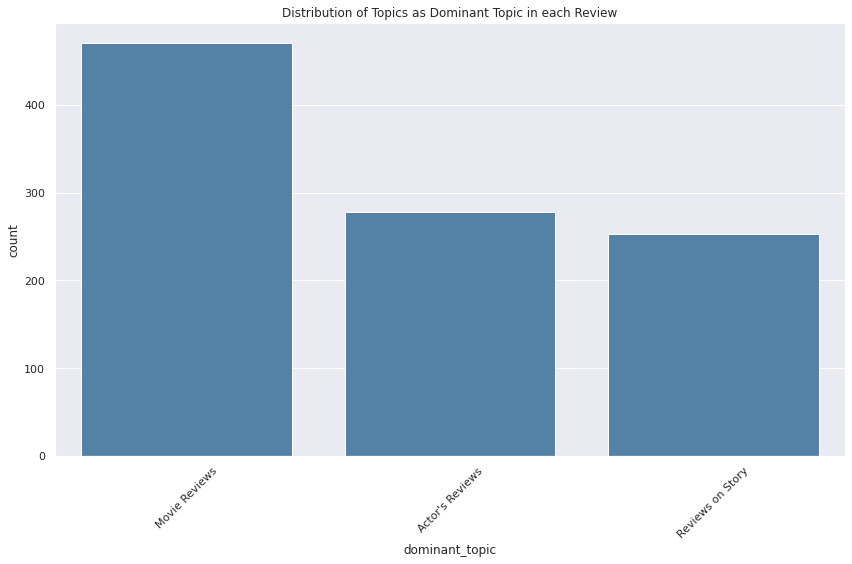

In [31]:
# Visualization of Frequency Distribution 

# Import libraries for visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Bar Chart
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.countplot( x = 'dominant_topic', data=df_dominant_topics,color='steelblue', order=df_dominant_topics['dominant_topic'].value_counts().index)
#ax.bar_label(ax.containers[0])
plt.title('Distribution of Topics as Dominant Topic in each Review')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()